# Tesla Stock Price Prediction using stacked LSTM

The data is collected in real time using Tiingo API and loaded using pandas_datareader

In [1]:
!pip install pandas_datareader

In [2]:
# this is the data loader which will load the stock prices using Tiingo API
import pandas_datareader as pdr
api_key = "<YOUR API KEY>"
# go to the below URL and sign up to create your API key
# https://api.tiingo.com/documentation/general/overview

In [3]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# we need to ensure that tensorflow version > 2.x
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
df = pdr.get_data_tiingo('TSLA', api_key=api_key)

In [6]:
# save the dataset for future use
df.to_csv('data/Tesla.csv')

In [7]:
# read saved dataset
df = pd.read_csv('data/Tesla.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-10-31 00:00:00+00:00,197.73,202.4900,195.8100,202.49,4692273,39.546,40.49800,39.16200,40.498,23461365,0.0,1.0
1,TSLA,2016-11-01 00:00:00+00:00,190.79,198.5000,188.1050,198.04,7060036,38.158,39.70000,37.62100,39.608,35300180,0.0,1.0
2,TSLA,2016-11-02 00:00:00+00:00,188.02,192.6951,187.5050,190.05,4253382,37.604,38.53902,37.50100,38.010,21266910,0.0,1.0
3,TSLA,2016-11-03 00:00:00+00:00,187.42,191.4700,187.0401,189.00,2653023,37.484,38.29400,37.40802,37.800,13265115,0.0,1.0
4,TSLA,2016-11-04 00:00:00+00:00,190.56,193.4600,185.9600,189.00,5146043,38.112,38.69200,37.19200,37.800,25730215,0.0,1.0


In [8]:
# we shall use the closing price of each day stocks as final labels
df_close = df.reset_index()['close']
df_close

0        197.73
1        190.79
2        188.02
3        187.42
4        190.56
         ...   
1254    1024.86
1255    1018.43
1256    1037.86
1257    1077.04
1258    1114.00
Name: close, Length: 1259, dtype: float64

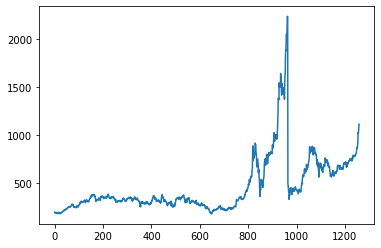

In [9]:
plt.plot(df_close)

In [10]:
# since LSTM is very sensitive to scaling we need to scale the data
scaler=MinMaxScaler(feature_range=(0,1))
df_c = scaler.fit_transform(np.array(df_close).reshape(-1,1))
print(df_c)

[[0.00910777]
 [0.00573848]
 [0.00439367]
 ...
 [0.41698143]
 [0.43600287]
 [0.45394654]]


In [11]:
# train and test split time series data
training_size=int(len(df_c)*0.80)
test_size=len(df_c)-training_size
train_data,test_data=df_c[0:training_size,:],df_c[training_size:len(df_c),:1]
print(train_data.shape, test_data.shape)

(1007, 1) (252, 1)


In [12]:
# create data matrix for lstm
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        part = dataset[i:(i+time_step), 0]  
        dataX.append(part)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# we shall use previous 80 days data for each LSTM learning
time_step = 80
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)
print(x_train.shape, y_train.shape)

(926, 80) (926,)


In [14]:
# reshape features from 2D to 3D as required by LSTM
n_features = 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] , n_features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] , n_features)
print(x_train.shape, x_test.shape)

(926, 80, 1) (171, 80, 1)


# LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [16]:
# create LSTM model
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 80, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [17]:
# model training
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
15/15 [==============================] - 12s 163ms/step - loss: 0.0143 - val_loss: 0.0063
Epoch 2/200
15/15 [==============================] - 1s 66ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 3/200
15/15 [==============================] - 1s 65ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 4/200
15/15 [==============================] - 1s 66ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 5/200
15/15 [==============================] - 1s 66ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 6/200
15/15 [==============================] - 1s 65ms/step - loss: 0.0043 - val_loss: 6.0266e-04
Epoch 7/200
15/15 [==============================] - 1s 66ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 8/200
15/15 [==============================] - 1s 65ms/step - loss: 0.0031 - val_loss: 4.7830e-04
Epoch 9/200
15/15 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 10/200
15/15 [==============================] - 1s 65ms/step - loss: 0.0026 - val_lo

## Predictions

In [18]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [19]:
# Transform back to original scale
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Metrics

In [20]:
import math
from sklearn.metrics import mean_squared_error

In [22]:
# we will use RMSE error metric
rmse_train = math.sqrt(mean_squared_error(y_train,train_predict))
rmse_test = math.sqrt(mean_squared_error(y_test,test_predict))
print(f"RMSE on train set: {round(rmse_train, 4)}")
print(f"RMSE on test set: {round(rmse_test, 4)}")

RMSE on train set: 515.5362
RMSE on test set: 696.0647


As from the RMSE error, the model might be a little underfitting. We can deal with this issue by: \
    1. Getting more training data. \
    2. Increasing the size or number of parameters or layers in the model. \
    3. Increasing the complexity of the model by using a bigger model. \
    4. Increasing the training time, until cost function is minimised.

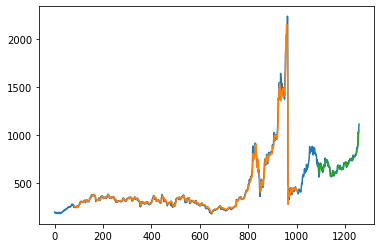

In [23]:
### Plotting 
# shift train predictions for plotting
look_back=80
trainPredictPlot = np.empty_like(df_c)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_c)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_c)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_c))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Future Predictions

In [24]:
x_input=list(test_data[(len(test_data)-look_back):].reshape(1,-1))
temp_input = x_input[0].tolist()
print(temp_input)

[0.23205390866985792, 0.24601170998844535, 0.23768072318402927, 0.23032071386264547, 0.22897105516123079, 0.22587363699035817, 0.22684461447339033, 0.23377739370224, 0.2312479973589412, 0.2283205002475992, 0.22546582644748464, 0.2323791861266737, 0.22614551068560712, 0.22721358591694257, 0.241957878996786, 0.24673994310071945, 0.25764887512258583, 0.257682859334492, 0.25825573604948093, 0.2600568992805056, 0.25251725912476086, 0.2596345240753866, 0.25780423151987103, 0.2567507209507811, 0.2637563234908582, 0.26129004068395645, 0.24623988969695787, 0.23630679004553884, 0.24760896794803322, 0.2400741826797036, 0.24337065123459783, 0.2560127780636766, 0.2570759984075969, 0.25839167289710546, 0.25351736593228397, 0.25874122479099704, 0.26796065599238744, 0.27029585683907986, 0.26950451019040866, 0.26867917932983126, 0.2692520560448203, 0.2786462631931565, 0.2791074774975968, 0.2795881113516977, 0.27056287564691367, 0.27383021487731696, 0.2745535931021759, 0.28005903543096833, 0.28062220237

In [26]:
# demonstrate prediction for next 10 days
lstm_output=[]
n_steps=80
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lstm_output.extend(yhat.tolist())
    else:
        print("{} day input {}".format(i,x_input))
        x_input = np.array(x_input).reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lstm_output.extend(yhat.tolist())
    i += 1
    
print(lstm_output)

0 day input [array([0.23205391, 0.24601171, 0.23768072, 0.23032071, 0.22897106,
       0.22587364, 0.22684461, 0.23377739, 0.231248  , 0.2283205 ,
       0.22546583, 0.23237919, 0.22614551, 0.22721359, 0.24195788,
       0.24673994, 0.25764888, 0.25768286, 0.25825574, 0.2600569 ,
       0.25251726, 0.25963452, 0.25780423, 0.25675072, 0.26375632,
       0.26129004, 0.24623989, 0.23630679, 0.24760897, 0.24007418,
       0.24337065, 0.25601278, 0.257076  , 0.25839167, 0.25351737,
       0.25874122, 0.26796066, 0.27029586, 0.26950451, 0.26867918,
       0.26925206, 0.27864626, 0.27910748, 0.27958811, 0.27056288,
       0.27383021, 0.27455359, 0.28005904, 0.2806222 , 0.28183592,
       0.26760139, 0.27207275, 0.27817048, 0.27899582, 0.28906971,
       0.29730845, 0.29060871, 0.29242929, 0.28959889, 0.28947266,
       0.2925361 , 0.29207974, 0.29312839, 0.2984008 , 0.29445863,
       0.29759003, 0.30428007, 0.30688229, 0.31039723, 0.32239365,
       0.33554069, 0.33270543, 0.33344823, 0.3471

## Plotting Predictions

In [27]:
og_day=np.arange(1,n_steps+1)
pred_day=np.arange(n_steps+1,n_steps+31)

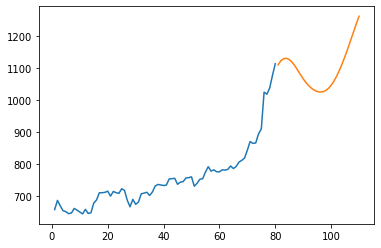

In [29]:
plt.plot(og_day,scaler.inverse_transform(df_c[(len(df_c)-n_steps):]))
plt.plot(pred_day,scaler.inverse_transform(lstm_output))

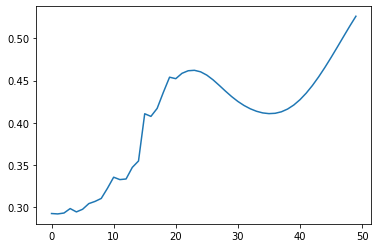

In [30]:
# plot last 20 days and next 30 days only
df2=df_c.tolist()
df2.extend(lstm_output)
plt.plot(df2[(len(df_c)-20):])

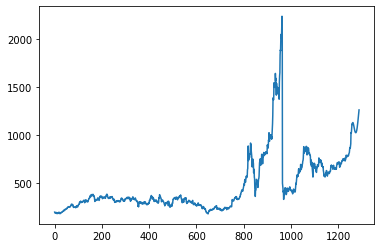

In [31]:
df3=scaler.inverse_transform(df2).tolist()
plt.plot(df3)